c:\Users\dasar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerModel(
  (input_layer): Linear(in_features=1, out_features=64, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (linear1): Linear(in_features=64, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=256, out_features=64, bias=True)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)


C:\Users\dasar\AppData\Local\Temp\ipykernel_25100\3346717499.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(x_test, dtype=torch.float32)


Normalized RMSE: 2553.9622


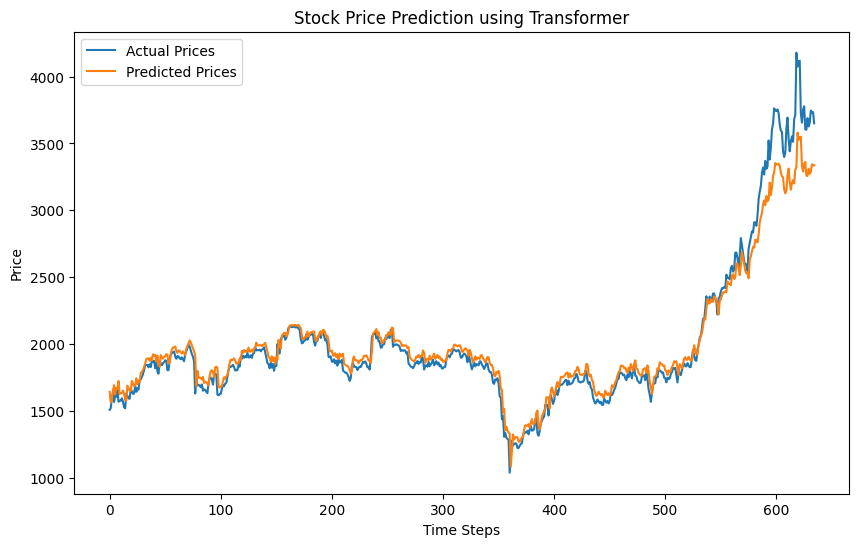

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Load the CSV file and preprocess
data = pd.read_csv("ADANIPORTS.csv")
series = data['Close'].values.reshape(-1, 1)#1D array to 2D array(needed for scaler)

# Normalize the data
scaler = MinMaxScaler()
series = scaler.fit_transform(series)

# Step 2: Split the data into training (80%) and testing (20%)
train_size = int(len(series) * 0.8)
train_data = series[:train_size]
test_data = series[train_size:]

# Step 3: Create sequences for the Transformer model
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

seq_length = 30  # Sequence length for the model
#tensor is a mathematical object that can represent data in multiple dimensions
x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

# Step 4: Use DataLoader for efficient batching
batch_size = 64 #64 30-sized input sequence are fed to model at a time
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Step 5: Define the Transformer Model with Encoder and Decoder
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, d_ff, output_dim):
        super(TransformerModel, self).__init__()
        self.input_layer = nn.Linear(input_dim, d_model)

        # Encoder
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_ff)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        # Decoder (same architecture as the encoder)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_ff)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)

        # Output layer
        self.fc = nn.Linear(d_model, output_dim)

    def forward(self, x, memory):#forward executes model logic
        x = self.input_layer(x)  # Convert input to the Transformer dimension
        memory = self.input_layer(memory)  # Create the memory for the decoder

        # Encoder
        memory = self.transformer_encoder(x)

        # Decoder
        output = self.transformer_decoder(x, memory)

        # Final output
        output = self.fc(output[:, -1, :])  # Take the output from the last time step
        return output

# Step 6: Initialize the model, loss function, and optimizer
input_dim = 1
d_model = 64  # Reduced dimension for faster computation
d_ff = 256  # Feed-forward layer size
output_dim = 1
nhead = 8  # Number of attention heads
num_layers = 1  # Number of Transformer layers

model = TransformerModel(input_dim=input_dim, d_model=d_model, nhead=nhead, num_layers=num_layers, d_ff=d_ff, output_dim=output_dim)
print(model)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 7: Training function
def train_model(model, train_loader, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        start_time = time.time()
        epoch_loss = 0.0
        for batch in train_loader:
            inputs, targets = batch
            optimizer.zero_grad()
            outputs = model(inputs, inputs)  # Using inputs as memory for the decoder
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        if epoch % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Time: {time.time() - start_time:.2f}s')

# Step 8: Train the model
train_model(model, train_loader, num_epochs=100)

# Step 9: Make predictions and inverse transform for visualization
model.eval()
with torch.no_grad():
    test_inputs = torch.tensor(x_test, dtype=torch.float32)
    predictions = model(test_inputs, test_inputs)  # Using test inputs as memory for the decoder

# Inverse transform the predictions and actual values for plotting
prediction_t = scaler.inverse_transform(predictions.detach().numpy())  # Inverse transform predictions

# Convert y_test to a NumPy array if it is a PyTorch tensor
y_test_np = y_test.numpy() if isinstance(y_test, torch.Tensor) else y_test

# Calculate RMSE and Normalized RMSE
rmse = np.sqrt(mean_squared_error(y_test_np, prediction_t))

# Calculate Normalized RMSE
normalized_rmse = rmse / (np.max(y_test_np) - np.min(y_test_np))

# Display the Normalized RMSE
print(f'RMSE: {normalized_rmse:.4f}')


# Step 10: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Prices')
plt.plot(prediction_t, label='Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.title('Stock Price Prediction using Transformer')
plt.legend()
plt.show()


In [13]:
d_model = 64
d_ff = 256  # generally d_ff = 4 * d_model 
n_heads = 8

# Parameters used for multi-head attention
mha = 4 * ((d_model ** 2) + d_model)
print(f'Parameters used for multi-head attention: {mha}')
print(f"As multi-head attention outputs ({d_model} x {d_model})matrix by concatenating {n_heads} key,query,value matrices of size ({d_model} x {d_model // n_heads})")

# Parameters used for feed-forward network
ffn = (4 * d_model * d_ff) + d_model + d_ff
print(f'Parameters used for feed-forward network: {ffn}')
print(f"As feed-forward layer outputs ({d_ff} x {d_model})matrix formed through linear,RELU,linear layers by taking ({d_model} x {d_ff})matrix")

# Parameters used for layer normalization
ln = 2 * d_model
print(f'Parameters used for layer normalization: {ln}')
print(f"As layer normalisation is made of beta and gamma vectors, each has a {d_model} dimension")
# Parameters used for encoder layer
el = mha + ffn + 2*ln
print(f'Parameters used for encoder layer: {el}')
print(f"as encoder layer fromed by series of feed forward network with layer normalisation followed by multiattentiona head with layer normalisation ")

# Parameters used for decoder layer
dl = 2 * mha + ffn + 3 * ln
print(f'Parameters used for decoder layer: {dl}')
print(f"as decoder layer is formed by series of feed forward network with layer normlaisation followed by 2 multihead attention with layer normalisation")

# Overall parameters used
total = el + dl
print(f'Overall used parameters count: {total}')


Parameters used for multi-head attention: 16640
As multi-head attention outputs (64 x 64)matrix by concatenating 8 key,query,value matrices of size (64 x 8)
Parameters used for feed-forward network: 65856
As feed-forward layer outputs (256 x 64)matrix formed through linear,RELU,linear layers by taking (64 x 256)matrix
Parameters used for layer normalization: 128
As layer normalisation is made of beta and gamma vectors, each has a 64 dimension
Parameters used for encoder layer: 82752
as encoder layer fromed by series of feed forward network with layer normalisation followed by multiattentiona head with layer normalisation 
Parameters used for decoder layer: 99520
as decoder layer is formed by series of feed forward network with layer normlaisation followed by 2 multihead attention with layer normalisation
Overall used parameters count: 182272


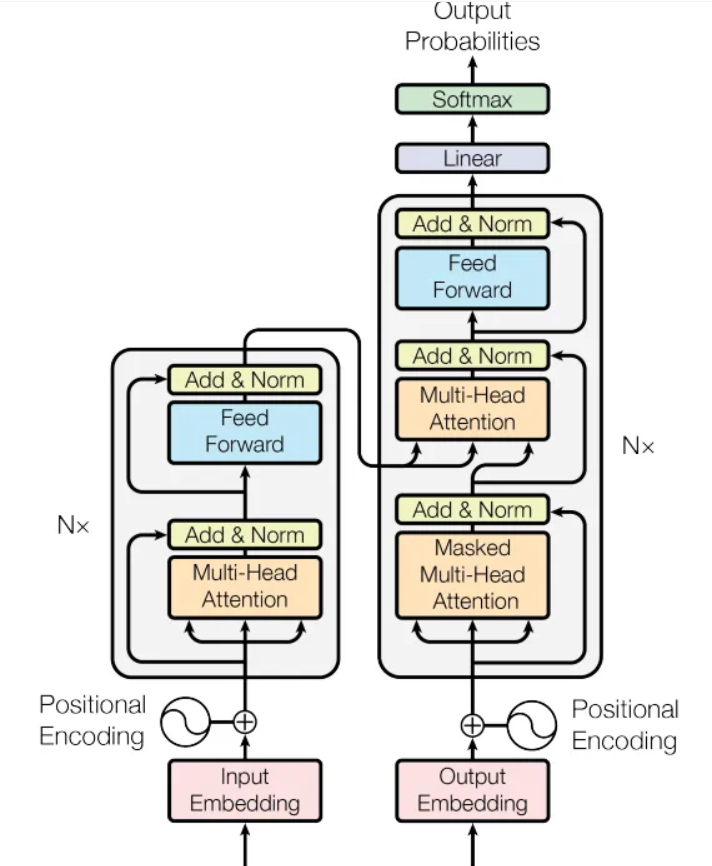